In [336]:
#We are going to create a Neural Network in order to predict a image classification of cats vs dogs


#PARAMETERS

##VARIABLES CHANGED
batch_size= 5
seedVal = 123;

#OPTIMIZERS
#opFunction = "Nesterov"
#opFunction="Adam"
opFunction="RMSprop"
NetStructure = "BN"
lr = 0.001
### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch

dtype = torch.cuda.FloatTensor
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# datetime
import datetime
now = datetime.datetime.now()

### OPTIONS #################################################################
# may want to later set from command line

# set random seed value

# at which epochs to record training/validation error
epochsConsidered = [3, 6,9]
saveNetEpochsConsidered = True;

### PATHS ###################################################################

pathTrain = './data/FinalProjectTrainValTest/Train/'
pathVal = './data/FinalProjectTrainValTest/Val/'
pathOutput = './output/'
############################

In [337]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose( #lookup transforms.compose
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# load the train and val dataset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,shuffle=True, num_workers=2)

valset = datasets.ImageFolder(root=pathVal, transform=transform)
valloader = torch.utils.data.DataLoader(valset, shuffle=True, num_workers=2)

###classes must be in alphabetical order
classes = ('Cats', 'Dogs')
classes = sorted(classes) 
print(classes)

['Cats', 'Dogs']


 Cats  Dogs  Cats  Cats  Cats


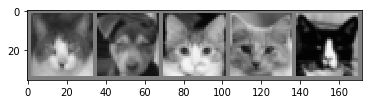

In [338]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #lookup np.transpose
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##Update
#print(images)

#print(labels) #Dont need to see this for now

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [339]:
#imshow(images[0])

In [340]:
classes = ['Cats','Dogs'];
for k in range(0,2): ### CAS: change to range(0,8)
    allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
    allValFiles = fnmatch.filter(os.listdir(pathVal+classes[k]), '*.tif');

In [341]:
###DEFINING A CONVOLUTIONAL NEURAL NETWORK ARCHITECTURE #######################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(input channels, output channels, size of the filter)
        self.pool = nn.MaxPool2d(2, 2) #size of the pool 2 by 2 matrix
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #(input sample, output sample)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80,2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.conv2_bn(x)
        x = x.view(-1, 16*5 * 5)
        x = F.relu(self.fc1(x)) #vector of size 1 by 120 
        x = F.relu(self.fc2(x)) #vector of size 1 by 84
        x = self.fc3(x)
        return x
    
net = Net()

In [342]:
### SET UP TO DETERMINE BEST NUMBER OF EPOCHS (HYPERPARAMETER)
# for each epoch considered, find the training and validation Accuracy
# initialize vectors here
trainAccuracy = [0]*len(epochsConsidered)
valAccuracy = [0]*len(epochsConsidered)
count = 0;

#IF statements for SGD Nesterov and Adam optimizer

if opFunction == "Nesterov":
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
if opFunction == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    
##ADDED A NEW OPTIMIZER##    
if opFunction == "RMSprop":
    optimizer = optim.RMSprop(net.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [343]:
# function to compute the percentage accuracy in categorizing images
def computeAccuracy(net, dataSubset):
    correct = 0
    total = 0
    # don't want batches, want to compute over the whole dataset
    dataSubsetLoader = torch.utils.data.DataLoader(dataSubset, num_workers=2)
    for data in dataSubsetLoader:
        images, labels = data  
        outputs = net(Variable(images))
        print(outputs)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()

    percentAccuracy = 100 * correct / total
    print('Accuracy of the network is: %d %%' % (
        percentAccuracy))
    
    return(percentAccuracy)

In [344]:
### TRAIN NETWORK ######################################################

# set random seed
random.seed(seedVal);

criterion = nn.CrossEntropyLoss() 
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)
##Added "nesterov = True" change maded on 3/25

### CAS: increased the number of epochs get better result
for epoch in range(np.max(epochsConsidered)):  # loop over the dataset multiple times  #We reduced the ranget (5)##

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        # print(loss.data)
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/5)) #try divide by 5
            running_loss = 0.0
            
    # For selected epochs, compute training and val (see note)
    # acccuracy, and save the network so that it can be reloaded
    if (epoch+1) in epochsConsidered:
        trainAccuracy[count] = computeAccuracy(net, trainset)
        valAccuracy[count] = computeAccuracy(net, valset)
        count = count + 1
        # save networks at the different epochs, to later load
        if (saveNetEpochsConsidered):
            saveFilename = str(now.strftime("%Y-%m-%d")) + ('Original%s_epochs.pth' % (epoch+1))
            savePath = os.path.join(pathOutput, 'networks', saveFilename)
            torch.save(net.cpu().state_dict(), savePath)
        
print('Finished Training')

[1,     5] loss: 0.918
[1,    10] loss: 0.669
[1,    15] loss: 0.691
[1,    20] loss: 0.705
[1,    25] loss: 0.621
[2,     5] loss: 0.536
[2,    10] loss: 0.553
[2,    15] loss: 0.369
[2,    20] loss: 0.445
[2,    25] loss: 0.432
[3,     5] loss: 0.310
[3,    10] loss: 0.293
[3,    15] loss: 0.488
[3,    20] loss: 0.383
[3,    25] loss: 0.306
Variable containing:
 0.0872 -1.1161
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9274 -1.9077
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9634 -2.4030
[torch.FloatTensor of size 1x2]

Variable containing:
 0.0411 -0.7623
[torch.FloatTensor of size 1x2]

Variable containing:
 1.0745 -2.4272
[torch.FloatTensor of size 1x2]

Variable containing:
 1.5235 -3.1853
[torch.FloatTensor of size 1x2]

Variable containing:
 0.0823 -0.8289
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3017 -2.8204
[torch.FloatTensor of size 1x2]

Variable containing:
 1.6158 -3.3464
[torch.FloatTensor of size 1x2]

Variable containing:
-0.6

Variable containing:
 0.0573 -0.8491
[torch.FloatTensor of size 1x2]

Variable containing:
 0.3751 -0.9679
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3124 -2.7629
[torch.FloatTensor of size 1x2]

Variable containing:
-0.2340 -0.1820
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1598 -2.4576
[torch.FloatTensor of size 1x2]

Variable containing:
-0.0467 -0.4882
[torch.FloatTensor of size 1x2]

Variable containing:
 1.0816 -2.1928
[torch.FloatTensor of size 1x2]

Variable containing:
-0.1443 -0.4800
[torch.FloatTensor of size 1x2]

Variable containing:
 0.4965 -1.1292
[torch.FloatTensor of size 1x2]

Variable containing:
-0.3014 -0.1673
[torch.FloatTensor of size 1x2]

Variable containing:
 0.6909 -1.5917
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8303 -1.7762
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8774 -1.9380
[torch.FloatTensor of size 1x2]

Variable containing:
-1.6753  1.6728
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 1.6104 -3.4910
[torch.FloatTensor of size 1x2]

Variable containing:
 0.7141 -1.5656
[torch.FloatTensor of size 1x2]

Variable containing:
 2.6115 -5.0051
[torch.FloatTensor of size 1x2]

Variable containing:
-0.9183  0.4349
[torch.FloatTensor of size 1x2]

Variable containing:
 2.4565 -4.6478
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3217 -2.8343
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3402 -4.4307
[torch.FloatTensor of size 1x2]

Variable containing:
-0.3205 -0.6294
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3354 -2.5758
[torch.FloatTensor of size 1x2]

Variable containing:
-0.1938 -0.7418
[torch.FloatTensor of size 1x2]

Variable containing:
 1.5067 -2.9686
[torch.FloatTensor of size 1x2]

Variable containing:
 2.2851 -4.3574
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0644 -3.8555
[torch.FloatTensor of size 1x2]

Variable containing:
-3.7660  3.9093
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 3.9743 -6.6269
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0011 -3.3291
[torch.FloatTensor of size 1x2]

Variable containing:
 4.2017 -6.9964
[torch.FloatTensor of size 1x2]

Variable containing:
-0.9141  0.4348
[torch.FloatTensor of size 1x2]

Variable containing:
 4.1625 -6.8942
[torch.FloatTensor of size 1x2]

Variable containing:
 3.1605 -5.2424
[torch.FloatTensor of size 1x2]

Variable containing:
 4.0160 -6.6546
[torch.FloatTensor of size 1x2]

Variable containing:
-0.7207 -0.1488
[torch.FloatTensor of size 1x2]

Variable containing:
 2.4026 -4.0170
[torch.FloatTensor of size 1x2]

Variable containing:
 0.0598 -1.0471
[torch.FloatTensor of size 1x2]

Variable containing:
 2.4970 -4.2789
[torch.FloatTensor of size 1x2]

Variable containing:
 4.1791 -6.9418
[torch.FloatTensor of size 1x2]

Variable containing:
 3.4717 -5.7635
[torch.FloatTensor of size 1x2]

Variable containing:
-4.5622  4.8164
[torch.FloatTensor of size 1x2]

Variable containing:

In [345]:
#Now we define a couple functions that will allow us to visualize the network. 
# The first gets the activations at a given layer for a given input image. 
#The second plots those activations in a grid.
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [346]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(tmp.shape[3] / n_columns)
    for i in range(0, filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [347]:
#Now we can choose an image to pass through the 
#network to visualize the network activation, 
#and look at the raw pixels of that image.

# dataiterval = iter(valloader)
# imagesVal, labelsVal = dataiter.next()
# ImageToUse = imagesVal[0]
# imshow(imageToUse)

In [348]:
# dataiterval = iter(valloader)
# imagesval, labelsval = dataiter.next()

# # print images
# imshow(tv.utils.make_grid(images))

# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [349]:
np.max(valAccuracy)

90.0

In [350]:
epochsConsidered[np.argmax(valAccuracy)]

6

In [351]:
trainAccuracy

[91.53846153846153, 98.46153846153847, 100.0]

In [352]:
trainAccuracy[np.argmax(valAccuracy)]

98.46153846153847

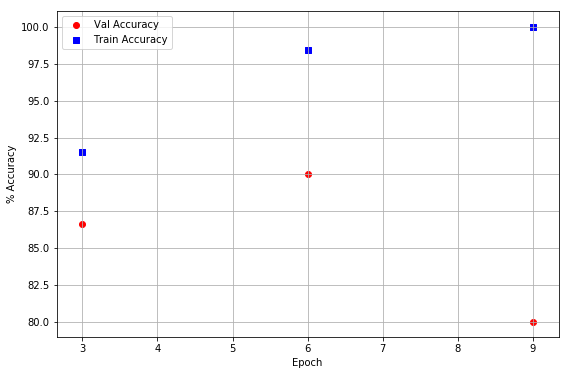

In [353]:
### FIGURE TO SHOW TRAIN AND VAL ERROR ############################

# initialize figure
plt.figure(figsize=(9, 6)) 

# the two scatter grap data sets
data1 = plt.scatter(epochsConsidered, valAccuracy, color='r', marker='o', label='Val Accuracy')
data2 = plt.scatter(epochsConsidered, trainAccuracy, color='b', marker='s', label='Train Accuracy')

# formatting
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.legend()
plt.grid()

# save to file
fig = plt.gcf()
fig.savefig(pathOutput + str(now.strftime("%Y-%m-%d")) + opFunction+"-" + str(lr)+"-" + str(seedVal)+"-"+ NetStructure+"-"+ str(batch_size)+
            '.png', bbox_inches="tight")